# Import packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

In [3]:
device

'cuda'

# Load datasets

In [4]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

# Create class for collecting data

In [4]:
class PriceDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor(labels[1]).float().to(device)

        return features, price

    def __len__(self):
        return len(self.features)

In [6]:
temp = PriceDataset(features, labels)
in_features = len(temp[0][0])

# Build the model

In [5]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

In [8]:
model = PredictPrice(in_features)
torchinfo.summary(model, input_size=(1, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
PredictPrice                             --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 128]                  6,656
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 128]                  16,512
│    └─ReLU: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 256]                  33,024
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Linear: 2-7                       [1, 128]                  32,896
│    └─ReLU: 2-8                         [1, 128]                  --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-9                       [1, 1]                    129
│    └─ReLU: 2-10                        [1, 1]                    --

# Data standardization

In [ ]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

# Train the model
## Prepare data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

# Cross validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/all_full_epoch_1000_fold_{}.pth".format(fold))

# Testing the performance

In [ ]:
filename = "models/sale_full_epoch_1000_fold_1.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [ ]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [ ]:
pred

In [ ]:
avg_error

# Number of sale and rental data

In [ ]:
features = pd.read_csv("../datasets/final_features.csv")
sale_rent = torch.tensor(features["Sale or Let"].values)
classes, count = sale_rent.unique(return_counts=True)

In [ ]:
classes, count

# Weighted random sampler

In [ ]:
weight = 1.0 / count.float()
weight

In [ ]:
sample_weights = weight[sale_rent.squeeze().long()]

In [ ]:
sample_weights[:10]

In [ ]:
sale_rent[:10]

In [ ]:
generator = torch.Generator()

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                generator=generator,
                                replacement=True)

In [ ]:
train_data = PriceDataset(features, labels)
train_loader = DataLoader(train_data, batch_size=2, sampler=sampler)

# Prepare data
## Load data

In [12]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

## Data standardization

In [13]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split dataset

In [14]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

## Cross validation



-------------This is fold 0----------------
EPOCH: 1000.000	val_loss: 1558161792.000	(2836.34s - 0.00s remaining))))))

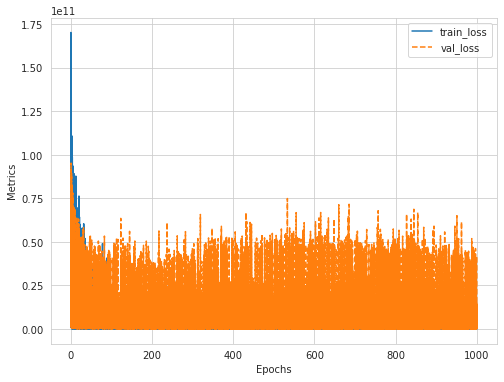



-------------This is fold 1----------------
EPOCH: 1000.000	val_loss: 2251513344.000	(2595.49s - 0.00s remaining)))))

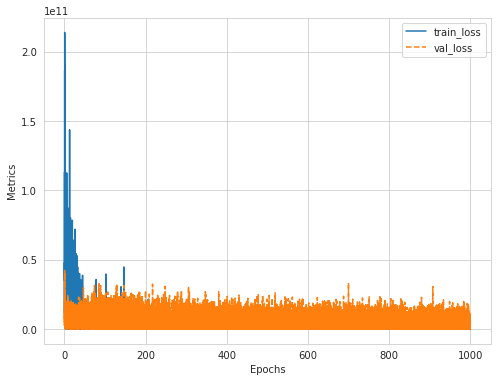



-------------This is fold 2----------------
EPOCH: 1000.000	val_loss: 1911453056.000	(2759.86s - 0.00s remaining)))))

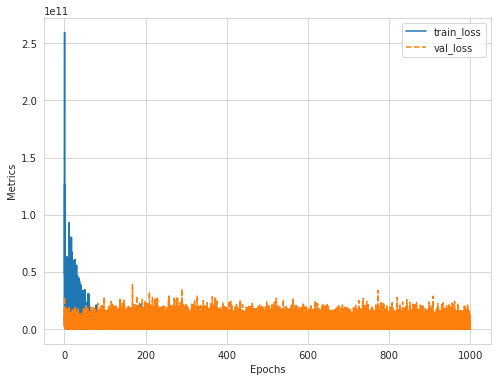



-------------This is fold 3----------------
EPOCH: 1000.000	val_loss: 4407289344.000	(2465.26s - 0.00s remaining)))))

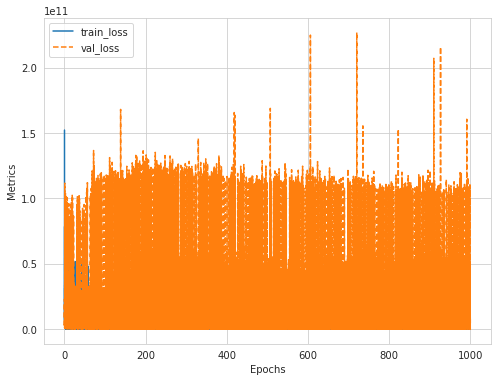



-------------This is fold 4----------------
EPOCH: 1000.000	val_loss: 38178177024.000	(2488.73s - 0.00s remaining)))))

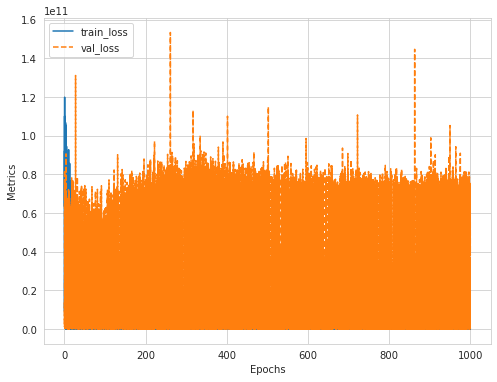

In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)

    train_sampler = create_weighted_sampler(train_feature["Sale or Let"].values)
    val_sampler = create_weighted_sampler(val_feature["Sale or Let"].values)

    train_loader = DataLoader(train_data, batch_size=16, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, drop_last=True, sampler=val_sampler)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/all_weighted_sampler_full_epoch_1000_fold_{}.pth".format(fold))

# Test performance (weighted sampler)

In [16]:
filename = "models/all_weighted_sampler_full_epoch_1000_fold_2.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [17]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [18]:
pred

,PredictPrice,Price,Error
3497,842.390564,525.0,0.604553
4669,348821.093750,270000.0,0.291930
5356,905768.000000,580000.0,0.561669
5835,551.455383,385.0,0.432352
8435,1037.775879,1400.0,0.258732
...,...,...,...
7173,868.048767,1300.0,0.332270
1392,522328.250000,520000.0,0.004477
3639,305598.312500,450000.0,0.320893
7216,1240.245605,750.0,0.653661


# Separate sale and rental data
## Load datasets

In [7]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

## Split sale and rental data

In [8]:
sale_features = features[features["Sale or Let"] == 1]
sale_features = sale_features.loc[:, ~sale_features.columns.isin(["Sale or Let"])]
sale_labels = labels.iloc[sale_features.index]

rental_features = features[features["Sale or Let"] == 0]
rental_features = rental_features.loc[:, ~rental_features.columns.isin(["Sale or Let"])]
rental_labels = labels.iloc[rental_features.index]

## Data standardization

In [9]:
scaler = StandardScaler()

scaler.fit(sale_features)
scaled_sale_feature = sale_features.copy()
scaled_sale_feature[:] = scaler.fit_transform(scaled_sale_feature)

scaler.fit(rental_features)
scaled_rental_feature = rental_features.copy()
scaled_rental_feature[:] = scaler.fit_transform(scaled_rental_feature)

## Split sale data into training and validation

In [10]:
x_train, x_test, y_train, y_test = train_test_split(scaled_sale_feature, sale_labels, random_state=1, test_size=0.1)

## Train the model

In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=16, drop_last=True, shuffle=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/sale_full_epoch_1000_fold_{}.pth".format(fold))



-------------This is fold 0----------------


KeyError: 'Sale or Let'

In [11]:
filename = "models/all_weighted_sampler_full_epoch_1000_fold_2.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [12]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [13]:
pred

,PredictPrice,Price,Error
3497,45845660.0,525.0,87324.066667
4669,186160224.0,270000.0,688.482311
5356,197736848.0,580000.0,339.925600
5835,164422848.0,385.0,427071.332468
8435,150515456.0,1400.0,107510.040000
...,...,...,...
7173,52173632.0,1300.0,40132.563077
1392,136921328.0,520000.0,262.310246
3639,150710944.0,450000.0,333.913209
7216,60319196.0,750.0,80424.594667


# Separate sale and rental data
## Loda datasets

In [ ]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

## Split sale and rental data

In [16]:
sale_features = features[features["Sale or Let"] == 1]
sale_features = sale_features.loc[:, ~sale_features.columns.isin(["Sale or Let"])]
sale_labels = labels.iloc[sale_features.index]

rental_features = features[features["Sale or Let"] == 0]
rental_features = rental_features.loc[:, ~rental_features.columns.isin(["Sale or Let"])]
rental_labels = labels.iloc[rental_features.index]

## Data standardization

In [19]:
scaler = StandardScaler()

scaler.fit(sale_features)
scaled_sale_feature = sale_features.copy()
scaled_sale_feature[:] = scaler.fit_transform(scaled_sale_feature)

scaler.fit(rental_features)
scaled_rental_feature = rental_features.copy()
scaled_rental_feature[:] = scaler.fit_transform(scaled_rental_feature)

## Split sale data into training and validation

In [20]:
x_train, x_test, y_train, y_test = train_test_split(scaled_sale_feature, sale_labels, random_state=1, test_size=0.1)

## Train the model

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)

    train_sampler = create_weighted_sampler(train_feature["Sale or Let"].values)
    val_sampler = create_weighted_sampler(val_feature["Sale or Let"].values)

    train_loader = DataLoader(train_data, batch_size=16, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, drop_last=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/sale_full_epoch_1000_fold_{}.pth".format(fold))



-------------This is fold 0----------------
EPOCH: 3.946	train_loss: 3095473920.000	(18.15s - 4580.12s remaining)))

KeyboardInterrupt: 